Commençons par charger et inspecter vos données.

In [1]:
import pandas as pd

# Charger les données à partir du fichier CSV
file_path = 'Danube ammonium level Time Series.csv'
data=pd.read_csv(file_path, sep=';')

# Afficher les premières lignes pour comprendre la structure des données
data.head()


,Months,Ammonium
0,01/01/1996,"0,253333"
1,01/02/1996,"0,218889"
2,01/03/1996,"0,242"
3,01/04/1996,"0,134545"
4,01/05/1996,"0,113333"


question  1


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Charger les données
file_path = 'Danube ammonium level Time Series.csv'
data = pd.read_csv(file_path, sep=';', parse_dates=['Months'], dayfirst=True)
data['Ammonium'] = data['Ammonium'].str.replace(',', '.').astype(float)

# Séparer les données pour l'apprentissage et le test
train_data = data[(data['Months'] >= '1996-01-01') & (data['Months'] <= '2016-12-01')]
test_data = data[(data['Months'] >= '2017-01-01') & (data['Months'] <= '2017-12-01')]

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data[['Ammonium']])
test_data_scaled = scaler.transform(test_data[['Ammonium']])

# Les données normalisées sont maintenant dans train_data_scaled et test_data_scaled


Pour préparer les données pour un réseau de neurones récurrent (RNN), on va les structurer de manière à ce que chaque observation contienne le taux d'ammonium à un instant t et le taux à l'instant t+1. Ce code définit une fonction create_dataset, qui transforme les données normalisées en paires (t, t+1). look_back est le nombre de pas de temps précédents à utiliser pour prédire la valeur suivante, ici réglé à 1. Les données d'apprentissage et de test sont ensuite transformées en utilisant cette fonction.

In [4]:
import numpy as np

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Créer les ensembles de données pour l'apprentissage et le test
look_back = 1
X_train, Y_train = create_dataset(train_data_scaled, look_back)
X_test, Y_test = create_dataset(test_data_scaled, look_back)

On construit un RNN 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(hp.Int('units', min_value=32, max_value=512, step=32), 
                        activation=hp.Choice('activation', values=['relu', 'tanh']),
                        input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # nombre de configurations à tester
    executions_per_trial=3,  # nombre d'itérations par configuration
    directory='my_dir',
    project_name='keras_tuner_demo'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Récupérer le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

# Entraîner le meilleur modèle
best_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Faire des prédictions avec le meilleur modèle
predictions = best_model.predict(X_test)

# Inverser la normalisation pour obtenir les vrais taux d'ammonium
predictions_inverse = scaler.inverse_transform(predictions)
true_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))


Trial 10 Complete [00h 00m 08s]
val_loss: 0.003044698853045702

Best val_loss So Far: 0.002649717420960466
Total elapsed time: 00h 01m 16s
Epoch 1/100
8/8 [==============================] - 1s 2ms/step - loss: 0.0261
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0176
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0175
E

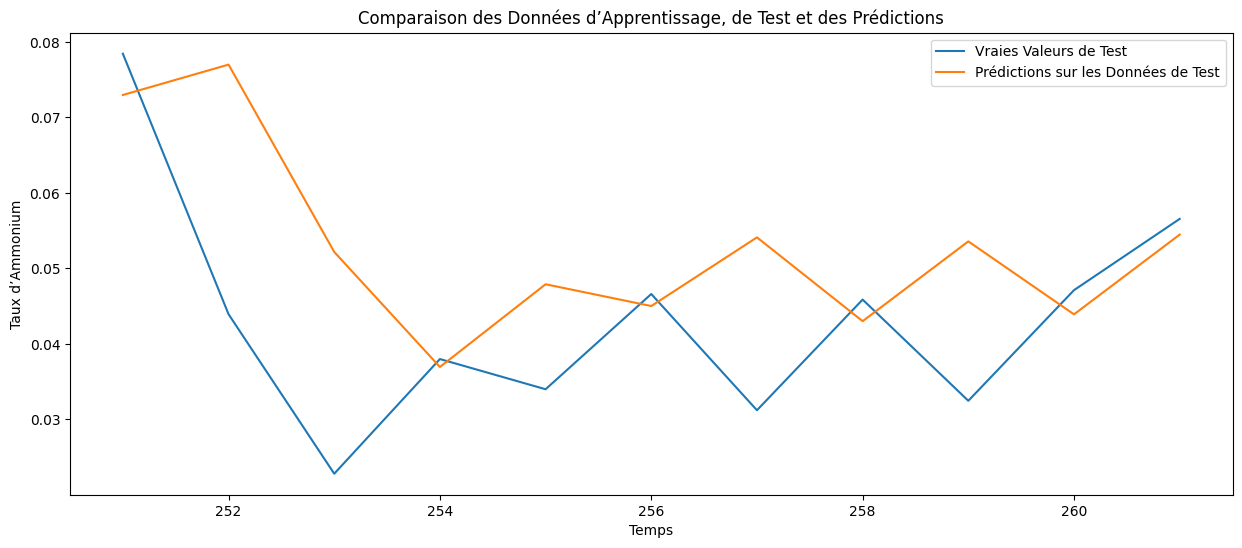

In [11]:
import matplotlib.pyplot as plt

# Comparer les vraies valeurs avec les prédictions
true_values = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Inverser la normalisation pour les données d'apprentissage
true_train = scaler.inverse_transform(Y_train.reshape(-1, 1))

# Préparer les indices de temps pour le traçage
time_train = range(len(true_train))
time_test = range(len(true_train), len(true_train) + len(true_predictions))

# Tracer les données d'apprentissage et de test avec les prédictions
plt.figure(figsize=(15, 6))
plt.plot(time_train, true_train, label='Données d’Apprentissage Réelles')
plt.plot(time_test, true_values, label='Vraies Valeurs de Test')
plt.plot(time_test, true_predictions, label='Prédictions sur les Données de Test')
plt.title('Comparaison des Données d’Apprentissage, de Test et des Prédictions')
plt.xlabel('Temps')
plt.ylabel('Taux d’Ammonium')
plt.legend()
plt.show()
